### Packages and Auxiliary Functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def tree_local_explanation(model, input_X, sample_id, labels_y=None):

    # The decision estimator has an attribute called tree_  which stores the entire
    # tree structure and allows access to low level attributes. The binary tree
    # tree_ is represented as a number of parallel arrays. The i-th element of each
    # array holds information about the node `i`. Node 0 is the tree's root. NOTE:
    # Some of the arrays only apply to either leaves or split nodes, resp. In this
    # case the values of nodes of the other type are arbitrary!
    #
    # Among those arrays, we have:
    #   - left_child, id of the left child of the node
    #   - right_child, id of the right child of the node
    #   - feature, feature used for splitting the node
    #   - threshold, threshold value at the node

    #n_nodes = # The decision estimator has an attribute called tree_  which stores the entire
    # tree structure and allows access to low level attributes. The binary tree
    # tree_ is represented as a number of parallel arrays. The i-th element of each
    # array holds information about the node `i`. Node 0 is the tree's root. NOTE:
    # Some of the arrays only apply to either leaves or split nodes, resp. In this
    # case the values of nodes of the other type are arbitrary!
    #
    # Among those arrays, we have:
    #   - left_child, id of the left child of the node
    #   - right_child, id of the right child of the node
    #   - feature, feature used for splitting the node
    #   - threshold, threshold value at the node

    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold

    # First let's retrieve the decision path of each sample. The decision_path
    # method allows to retrieve the node indicator functions. A non zero element of
    # indicator matrix at the position (i, j) indicates that the sample i goes
    # through the node j.

    node_indicator = model.decision_path(input_X)

    # Similarly, we can also have the leaves ids reached by each sample.

    leave_id = model.apply(input_X)

    # Now, it's possible to get the tests that were used to predict a sample or
    # a group of samples. First, let's make it for the sample.

    # HERE IS WHAT YOU WANT
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    print('Rules used to predict sample %s: ' % sample_id)
    for node_id in node_index:

        if leave_id[sample_id] == node_id:  # <-- changed != to ==
            #continue # <-- comment out
            y_pred = (model.predict(X_ub.iloc[sample_id].values.reshape(1, -1)))
            print("terminal/leaf node %s reached, decision is %s" % (leave_id[sample_id], 
                                                                    labels_y[int(y_pred)]) ) # <--

        else: # < -- added else to iterate through decision nodes
            if (input_X.iloc[sample_id][feature[node_id]] <= threshold[node_id]):
                threshold_sign = "<="
            else:
                threshold_sign = ">"

            print("(decision node %s, individual %s has %s = %s) %s %s, goes to"
                  % (node_id,
                     sample_id,
                     X_ub.columns[node_id],
                     input_X.iloc[sample_id][feature[node_id]], # <-- changed i to sample_id
                     threshold_sign,
                     threshold[node_id]))
    print()


## Import data

### Load data from Github Repo

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/code_club/master/mortgage_data_balanced.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'respondent_id', 'as_of_year', 'agency_abbr',
       'loan_type_name', 'loan_amount_000s', 'owner_occupancy_name',
       'loan_purpose_name', 'property_type_name', 'preapproval_name',
       'msamd_name', 'state_abbr', 'county_name', 'applicant_ethnicity_name',
       'co_applicant_ethnicity_name', 'applicant_race_name_1',
       'co_applicant_race_name_1', 'applicant_sex_name',
       'co_applicant_sex_name', 'applicant_income_000s', 'purchaser_type_name',
       'denial_reason_name_1', 'hoepa_status_name', 'lien_status_name',
       'population', 'minority_population', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units', 'action_taken_name'],
      dtype='object')

### Initial Organization and Exploration

In [5]:
keep_vars = ['respondent_id', 'as_of_year', 'agency_abbr', 'loan_type_name', 'loan_amount_000s', 'owner_occupancy_name',
             'loan_purpose_name', 'property_type_name', 'preapproval_name', 'msamd_name', 'state_abbr', 'county_name',
             'applicant_ethnicity_name', 'co_applicant_ethnicity_name', 'applicant_race_name_1', 'co_applicant_race_name_1',
             'applicant_sex_name', 'co_applicant_sex_name', 'applicant_income_000s', 'purchaser_type_name', 
             'denial_reason_name_1', 'hoepa_status_name', 'lien_status_name', 'population', 'minority_population',
             'hud_median_family_income', 'tract_to_msamd_income', 'number_of_owner_occupied_units', 
             'number_of_1_to_4_family_units', 'action_taken_name']

df = df[keep_vars].copy()

In [6]:
df['action_taken_name'].value_counts()

Loan originated                                2513
Application denied by financial institution    2487
Name: action_taken_name, dtype: int64

In [7]:
pd.crosstab(df["applicant_ethnicity_name"], df["action_taken_name"])/5000 * 100.0

action_taken_name,Application denied by financial institution,Loan originated
applicant_ethnicity_name,,
Hispanic or Latino,4.16,2.50
Not Hispanic or Latino,45.58,47.76


In [8]:
pd.crosstab(df["applicant_race_name_1"], df["action_taken_name"])/5000 * 100.0

action_taken_name,Application denied by financial institution,Loan originated
applicant_race_name_1,,
American Indian or Alaska Native,0.52,0.18
Asian,2.66,3.26
Black or African American,5.68,2.24
Native Hawaiian or Other Pacific Islander,0.26,0.06
White,40.62,44.52


In [9]:
pd.crosstab(df["applicant_sex_name"], df["action_taken_name"])/5000 * 100.0

action_taken_name,Application denied by financial institution,Loan originated
applicant_sex_name,,
Female,16.66,13.44
Male,33.08,36.82


In [10]:
# categorical variables
cat_variables = cat_variables = ['applicant_ethnicity_name', 'applicant_race_name_1', 'applicant_sex_name', 'agency_abbr',
                                 'owner_occupancy_name', 'property_type_name', 'loan_purpose_name', 'loan_type_name']

# other integer variables
int_variables = ['loan_amount_000s', 'applicant_income_000s', 'population', 'minority_population', 
                 'hud_median_family_income', 'tract_to_msamd_income', 'number_of_owner_occupied_units', 
                 'number_of_1_to_4_family_units']

# target variable
output_variable = ['action_taken_name']

### Pre-processing
# Mapping categorical variables to one-hot encoding
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

# consolidating a final dataset
X = pd.concat([df[int_variables], df_cat], axis=1)
y = (df[output_variable] == "Loan originated").copy()

# removing race, ethnicity, sex and minority population from X
X_ub = X[[
    'loan_amount_000s', 'applicant_income_000s', 'population', 'hud_median_family_income', 'tract_to_msamd_income', 
    'number_of_owner_occupied_units', 'number_of_1_to_4_family_units', 'agency_abbr_CFPB', 'agency_abbr_FDIC',
       'agency_abbr_FRS', 'agency_abbr_HUD', 'agency_abbr_NCUA',
       'agency_abbr_OCC', 'owner_occupancy_name_Not applicable',
       'owner_occupancy_name_Not owner-occupied as a principal dwelling',
       'owner_occupancy_name_Owner-occupied as a principal dwelling',
       'property_type_name_Manufactured housing',
       'property_type_name_One-to-four family dwelling (other than manufactured housing)',
       'loan_purpose_name_Home improvement', 'loan_purpose_name_Home purchase',
       'loan_purpose_name_Refinancing', 'loan_type_name_Conventional',
       'loan_type_name_FHA-insured', 'loan_type_name_FSA/RHS-guaranteed',
       'loan_type_name_VA-guaranteed'
]].copy()

# protected attributtes
X_groups = X[[
    'minority_population', 'applicant_ethnicity_name_Hispanic or Latino',
       'applicant_ethnicity_name_Not Hispanic or Latino',
       'applicant_race_name_1_American Indian or Alaska Native',
       'applicant_race_name_1_Asian',
       'applicant_race_name_1_Black or African American',
       'applicant_race_name_1_Native Hawaiian or Other Pacific Islander',
       'applicant_race_name_1_White', 'applicant_sex_name_Female',
       'applicant_sex_name_Male'
]].copy()


In [11]:
X_ub.describe()

,loan_amount_000s,applicant_income_000s,population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,agency_abbr_CFPB,agency_abbr_FDIC,agency_abbr_FRS,...,owner_occupancy_name_Owner-occupied as a principal dwelling,property_type_name_Manufactured housing,property_type_name_One-to-four family dwelling (other than manufactured housing),loan_purpose_name_Home improvement,loan_purpose_name_Home purchase,loan_purpose_name_Refinancing,loan_type_name_Conventional,loan_type_name_FHA-insured,loan_type_name_FSA/RHS-guaranteed,loan_type_name_VA-guaranteed
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,...,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,188.47100,100.106400,5739.743600,69228.460000,115.593274,1601.492800,2063.751600,0.533400,0.07520,0.02820,...,0.890800,0.030800,0.969200,0.07520,0.289200,0.63560,0.806200,0.146000,0.014800,0.033000
std,164.32887,112.223575,2936.536592,14070.949447,37.167028,906.289128,1113.332253,0.498933,0.26374,0.16556,...,0.311921,0.172793,0.172793,0.26374,0.453436,0.48131,0.395314,0.353142,0.120764,0.178654
min,1.00000,1.000000,500.000000,16300.000000,23.190001,19.000000,43.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,86.00000,45.000000,3788.750000,60000.000000,91.677500,1021.000000,1346.750000,0.000000,0.00000,0.00000,...,1.000000,0.000000,1.000000,0.00000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
50%,149.00000,73.000000,5197.500000,66600.000000,109.535000,1443.000000,1847.000000,1.000000,0.00000,0.00000,...,1.000000,0.000000,1.000000,0.00000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000
75%,247.00000,119.000000,6955.000000,76700.000000,132.440002,1967.750000,2484.000000,1.000000,0.00000,0.00000,...,1.000000,0.000000,1.000000,0.00000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000
max,2500.00000,2000.000000,34055.000000,111900.000000,390.839996,9880.000000,10724.000000,1.000000,1.00000,1.00000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [12]:
y.describe()

,action_taken_name
count,5000
unique,2
top,True
freq,2513


# Model-specific Explanations

## Decision-trees (https://scikit-learn.org/stable/modules/tree.html#tree)

#### Set model

In [13]:
# fit and cross-validate model
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

## classification tree
model = DecisionTreeClassifier(max_depth=5, criterion="gini", class_weight="balanced")

## performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss
               } # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

## 10-fold cv
k_folds = StratifiedKFold(n_splits=10, random_state=10, shuffle=True) # https://scikit-learn.org/stable/modules/cross_validation.html

#### Fit and Validate

In [14]:
df_metrics = pd.DataFrame(index=range(10), columns=perf_metrics.keys())

# main loop
k = 0
for (train, test) in k_folds.split(X_ub, y):
    # fit model
    model.fit(X_ub.values[train], y.values[train])
       
    # test model
    ypred_class = model.predict(X_ub.values[test])
    ypred_prob = model.predict_proba(X_ub.values[test])[:, 1]

    # compute performance metrics
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            df_metrics.loc[k, pf] = perf_metrics[pf](y.values[test], ypred_prob)
        else:
            df_metrics.loc[k, pf] = perf_metrics[pf](y.values[test], ypred_class)
    k += 1

#### Performance metrics

In [15]:
df_metrics

,Accuracy,Precision,Recall,AUC,F1-Score,Brier
0,0.664,0.641892,0.753968,0.700845,0.693431,0.221092
1,0.61,0.622318,0.575397,0.6833,0.597938,0.223032
2,0.628,0.606452,0.746032,0.659546,0.669039,0.229904
3,0.604,0.58104,0.756972,0.668851,0.657439,0.23063
4,0.582,0.585366,0.573705,0.644706,0.579477,0.234792
5,0.602,0.602362,0.609562,0.641786,0.605941,0.239515
6,0.602,0.592857,0.661355,0.649146,0.625235,0.23581
7,0.614,0.621849,0.589641,0.672723,0.605317,0.227067
8,0.578,0.568027,0.665339,0.623954,0.612844,0.241415
9,0.634,0.621429,0.693227,0.687203,0.655367,0.222125


In [16]:
df_metrics.mean()

Accuracy     0.611800
Precision    0.604359
Recall       0.662520
AUC          0.663206
F1-Score     0.630203
Brier        0.230538
dtype: float64

In [17]:
df_metrics.mean()

Accuracy     0.611800
Precision    0.604359
Recall       0.662520
AUC          0.663206
F1-Score     0.630203
Brier        0.230538
dtype: float64

### Global Explanations

In [18]:
from sklearn.tree import export_graphviz
export_graphviz(model, out_file="class_tree.dot", feature_names=X_ub.columns, 
                class_names = ["Denied", "Originated"], rounded = True)

#### go to http://webgraphviz.com/ and paste class_tree.dot text

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli5\lib\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli5\lib\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Income 000s')

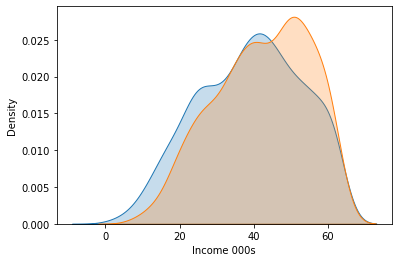

In [19]:
denied_income = X.loc[((y.values == 0) & 
                            (X["applicant_income_000s"].values.reshape(-1, 1) <= 63.5)).reshape(1, -1)[0], 
                           'applicant_income_000s']
originated_income = X.loc[((y.values == 1) & 
                          (X["applicant_income_000s"].values.reshape(-1, 1) <= 63.5)).reshape(1, -1)[0], 
                         'applicant_income_000s']
ax = sns.kdeplot(denied_income, shade=True, shade_lowest=False, label="Denied")
ax = sns.kdeplot(originated_income, shade=True, shade_lowest=False, label="Originated")
ax.set_xlabel("Income 000s")

### Local Explanations

In [20]:
tree_local_explanation(model, X_ub, 10, labels_y=["Loan rejected", "Loan originated"])

Rules used to predict sample 10: 
(decision node 0, individual 10 has loan_amount_000s = 22.0) <= 63.5, goes to
(decision node 1, individual 10 has applicant_income_000s = 3.0) <= 38.5, goes to
(decision node 2, individual 10 has population = 1.0) > 0.5, goes to
(decision node 10, individual 10 has agency_abbr_HUD = 3245.0) > 180.5, goes to
(decision node 12, individual 10 has agency_abbr_OCC = 115.69000244140624) > 39.560001373291016, goes to
terminal/leaf node 14 reached, decision is Loan rejected



# Model-agnostic

## Feed Forward Neural Network (https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

#### Set model

In [21]:
# fit and cross-validate model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

## neural net
model = Pipeline( (
        ("pre", StandardScaler()),
        ("nn", MLPClassifier(hidden_layer_sizes=(50, 50, ), 
                             activation='relu', solver="lbfgs", random_state=10))
) ) # https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators


## performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss
               }

## 10-fold cv
k_folds = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)

#### Fit and validate

In [22]:
df_metrics = pd.DataFrame(index=range(10), columns=perf_metrics.keys())

# main loop
k = 0
for (train, test) in k_folds.split(X_ub, y):
    # fit model
    model.fit(X_ub.values[train], y.values[train])
       
    # test model
    ypred_class = model.predict(X_ub.values[test])
    ypred_prob = model.predict_proba(X_ub.values[test])[:, 1]

    # compute performance metrics
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            df_metrics.loc[k, pf] = perf_metrics[pf](y.values[test], ypred_prob)
        else:
            df_metrics.loc[k, pf] = perf_metrics[pf](y.values[test], ypred_class)
    k += 1

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli5\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli5\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Koshiyama\Anaco

#### Performance metrics

In [23]:
df_metrics

,Accuracy,Precision,Recall,AUC,F1-Score,Brier
0,0.584,0.594017,0.551587,0.630728,0.572016,0.313863
1,0.626,0.631579,0.619048,0.658314,0.625251,0.281657
2,0.616,0.623967,0.599206,0.632136,0.611336,0.305751
3,0.62,0.623482,0.613546,0.63217,0.618474,0.296391
4,0.6,0.597701,0.621514,0.626058,0.609375,0.304643
5,0.578,0.57874,0.585657,0.591017,0.582178,0.324343
6,0.624,0.632911,0.59761,0.648362,0.614754,0.28889
7,0.58,0.577358,0.609562,0.603834,0.593023,0.319427
8,0.576,0.575875,0.589641,0.582041,0.582677,0.334515
9,0.614,0.626087,0.573705,0.628474,0.598753,0.306795


In [24]:
df_metrics.mean()

Accuracy     0.601800
Precision    0.606172
Recall       0.596108
AUC          0.623314
F1-Score     0.600784
Brier        0.307627
dtype: float64

### Global 

#### Permutation importance (https://scikit-learn.org/stable/modules/permutation_importance.html)

<AxesSubplot:ylabel='Variable'>

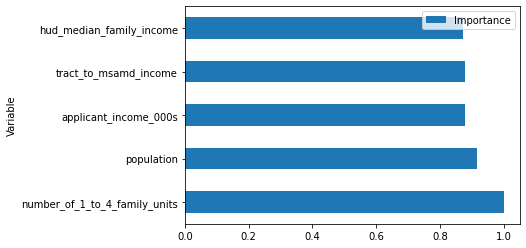

In [25]:
from sklearn.inspection import permutation_importance
feat_imp = permutation_importance(model, X_ub, y, n_repeats=5, random_state=10)
df_featimp = pd.DataFrame({"Variable": X_ub.columns,
                           "Importance": feat_imp['importances_mean']/feat_imp["importances_mean"].max()})
df_featimp = df_featimp.sort_values("Importance", ascending=False)

# chart
df_featimp.iloc[:5].plot(x="Variable", y="Importance", kind="barh")

#### Partial dependence (https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence)

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli5\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:323: FutureWarning: The fig parameter is deprecated in version 0.22 and will be removed in version 0.24
  FutureWarning)


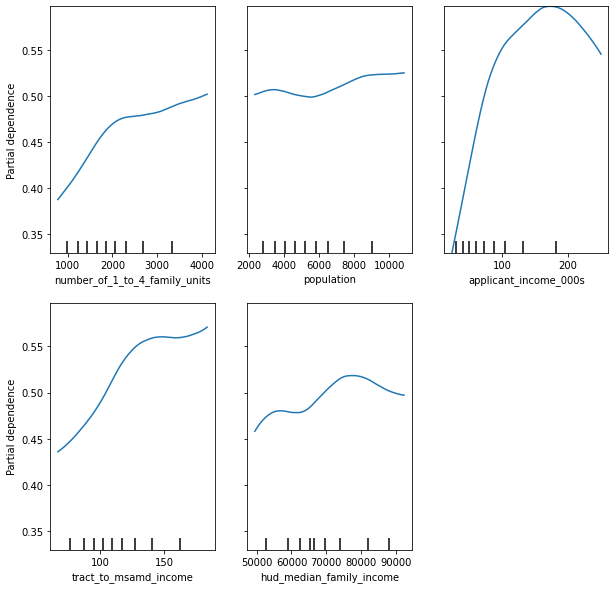

In [26]:
from sklearn.inspection import plot_partial_dependence
fig, ax = plt.subplots(figsize=(10, 10))
plot_partial_dependence(model, X_ub, df_featimp.iloc[:5].index, 
                        fig=fig, response_method="predict_proba", 
                        method="brute", grid_resolution=200
                       ) 

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_partial_dependence(model, X_ub, [(df_featimp.index[0], df_featimp.index[1])], fig=fig, 
                        response_method="predict_proba", method="brute")

## Local

### LIME Algorithm (https://github.com/marcotcr/lime)

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_ub.values, feature_names=X_ub.columns.tolist(), 
                                                   class_names=["Loan denied", "Loan originated"], discretize_continuous=True)

sample_id = 10
exp = explainer.explain_instance(X_ub.iloc[sample_id], model.predict_proba, num_features=7, top_labels=1)
exp.show_in_notebook()